# Hyperparameters tuning (Estimators of the longitudinal frequencies)

The estimators HistGradientBoosting and LightGBM showed the best scores during the benchmark and the cross-validation. In this notebook we will tune their hyperparameters with a Bayesian approach to optimize the precisions.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import seaborn as sns

## Load variables and target

In the first step we load the dataset again and define the explanatory and target variables again:

In [2]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [3]:
lst_param = df_params.columns.to_list()

In [4]:
# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
# Target variable is the frequency of the longitudinal mode
target = 'freq_long'

X = df_params[lst_expl + lst_slot_class]
y = df_params[target]

In [5]:
# New Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

We define a pipeline containing 2 steps: the scaling of the variables and the regressor. The optimization with BayesSearchCV will run on the pipeline.


## HistGradientBoosting

In [10]:
# Create the main pipeline
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

base_regressor = HistGradientBoostingRegressor()

pipe_base_hist = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', base_regressor)
                        ])

In [11]:
params_hist = {'regressor__loss': Categorical(['squared_error', 'absolute_error', 'gamma', 'poisson']),
                'regressor__max_iter': Integer(500, 5000),
                'regressor__max_depth': Integer(2, 8),
                'regressor__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'regressor__min_samples_leaf': Integer(10, 150),
                'regressor__l2_regularization': Real(1e-3, 1e2, prior='log-uniform')}

bayes_search_hist = BayesSearchCV(estimator=pipe_base_hist,
                             search_spaces=params_hist,
                             n_iter=32,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             n_jobs=-1)

In [12]:
# Perform the bayesian search
bayes_search_hist.fit(X_train, y_train)
print ('Best score:', bayes_search_hist.best_score_)
print ('Best parameters:', bayes_search_hist.best_params_)
print ('Score of the test set:', bayes_search_hist.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

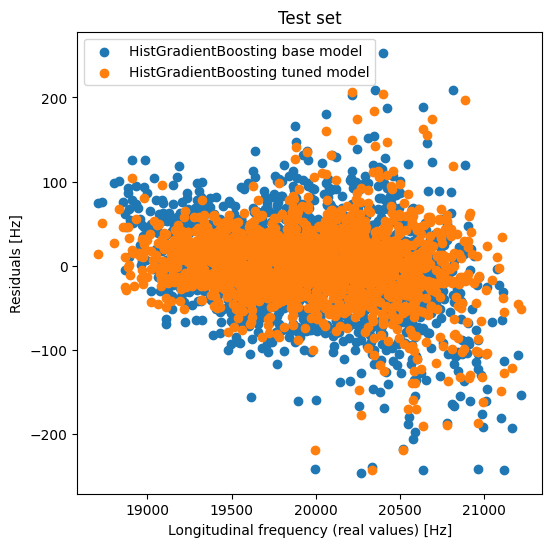

In [13]:
pipe_base_hist.fit(X_train, y_train)
y_pred_base_hist = pipe_base_hist.predict(X_test)
y_pred_tuned_hist = bayes_search_hist.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_base_hist-y_test, label='HistGradientBoosting base model')
plt.scatter(y_test, y_pred_tuned_hist-y_test, label='HistGradientBoosting tuned model')
plt.xlabel('Longitudinal frequency (real values) [Hz]')
plt.ylabel('Residuals [Hz]')
plt.title('Test set')
plt.legend()
plt.show()

After the hyperparameters tuning it is possible to compare the results of both models: the reducing of the frequency residuals confirms that the model is more precise with the optimized hyperparameters.

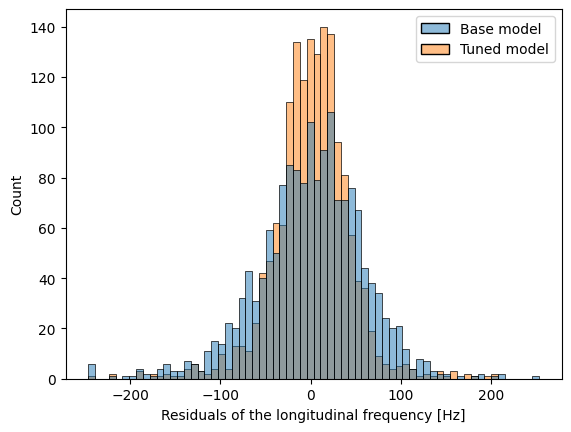

In [14]:
residuals = pd.DataFrame()
residuals['Base model'] = y_pred_base_hist-y_test
residuals['Tuned model'] = y_pred_tuned_hist-y_test
sns.histplot(data=residuals, fill=True)
plt.xlabel('Residuals of the longitudinal frequency [Hz]')
plt.show()

## LightGBM Regressor

This estimator was proposed by FLAML with specific hyperparameters, that were already fitted during the benchmark test. The first defined pipeline "pipe_base_lgbm" contains the base estimator (LigthGBM with standard parameters) and the second pipeline "pipe_start_lgbm" uses the parameters found after the FLAML fit.

In [15]:
# Create the main pipeline
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

base_regressor = LGBMRegressor(force_col_wise=True)

start_regressor = LGBMRegressor(n_estimators=8000,
                      num_leaves=6,
                      min_child_samples=7,
                      learning_rate=6.8e-2,
                      colsample_bytree=0.66,
                      reg_alpha=1.6e-3,
                      reg_lambda=1.3e-2,
                      force_col_wise=True)

pipe_base_lgbm = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', base_regressor)
                        ])

pipe_start_lgbm = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', start_regressor)
                        ])


In [16]:
params_lgbm = {'regressor__n_estimators': Integer(5000, 15000),
                'regressor__num_leaves': Integer(4, 8),
                'regressor__min_child_samples': Integer(5, 20),
                'regressor__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'regressor__reg_alpha': Real(1e-5, 1e0, prior='log-uniform'),
                'regressor__reg_lambda': Real(1e-5, 1e0, prior='log-uniform')}

bayes_search_lgbm = BayesSearchCV(estimator=pipe_start_lgbm,
                             search_spaces=params_lgbm,
                             n_iter=64,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             n_jobs=-1)


In [17]:
# Perform the bayesian search
bayes_search_lgbm.fit(X_train, y_train)
print ('Best score:', bayes_search_lgbm.best_score_)
print ('Best parameters:', bayes_search_lgbm.best_params_)
print ('Score of the test set:', bayes_search_lgbm.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [18]:
# Fit the base and start estimators
pipe_base_lgbm.fit(X_train, y_train)
pipe_start_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 19960.326050
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 19960.326050


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['dim_x', 'dim_y', 'dim_z',
                                                   'slot_x_length',
                                                   'slot_x_distance',
                                                   'slot_z_length',
                                                   'slot_z_distance',
                                                   'chamfer_x_dim_y',
                                                   'chamfer_x_dim_z',
                                                   'chamfer_y_dim_x',
                                                   'chamfer_y_dim_z',
                                                   'chamfer_z_dim_x',
                                                   'chamfer_z_dim_y',
                                                   'elefoot_x', 'elefoot_z',
                                                   'cut_x_start', 'cut_x_end',
                                                   'cut_x_depth', 'cut_z_start',
                                                   'cut_z_end', 'cut_z_depth',
                                                   'seg_x_out', 'seg_z_out']),
                                                 ('categorical', 'passthrough',
                                                  ['slot_2-2', 'slot_3-2',
                                                   'slot_4-1', 'slot_4-2'])])),
                ('regressor',
                 LGBMRegressor(colsample_bytree=0.66, force_col_wise=True,
                               learning_rate=0.068, min_child_samples=7,
                               n_estimators=8000, num_leaves=6,
                               reg_alpha=0.0016, reg_lambda=0.013))])

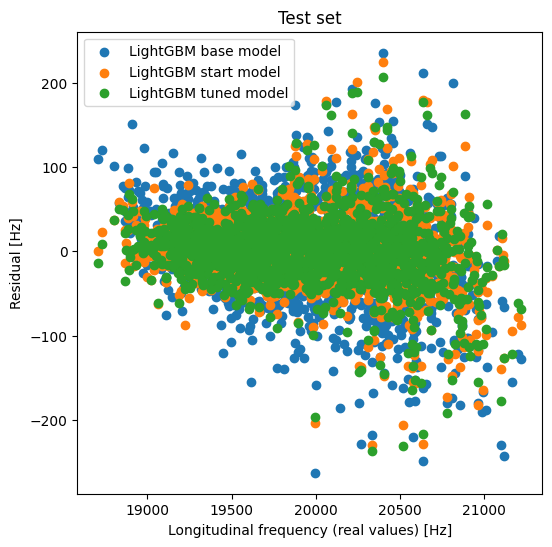

In [19]:
y_pred_base_lgbm = pipe_base_lgbm.predict(X_test)
y_pred_start_lgbm = pipe_start_lgbm.predict(X_test)
y_pred_tuned_lgbm = bayes_search_lgbm.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_base_lgbm-y_test, label='LightGBM base model')
plt.scatter(y_test, y_pred_start_lgbm-y_test, label='LightGBM start model')
plt.scatter(y_test, y_pred_tuned_lgbm-y_test, label='LightGBM tuned model')
plt.xlabel('Longitudinal frequency (real values) [Hz]')
plt.ylabel('Residual [Hz]')
plt.title('Test set')
plt.legend()
plt.show()

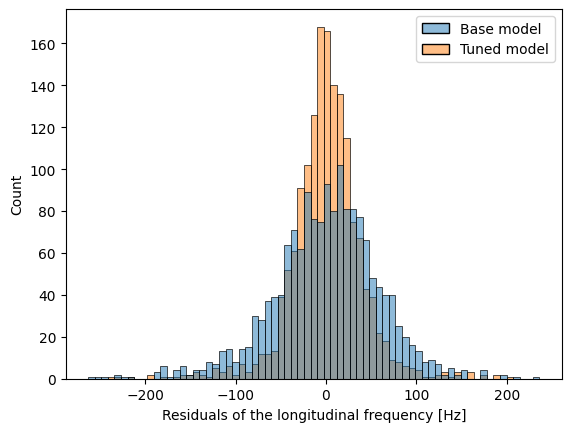

In [20]:
residuals = pd.DataFrame()
residuals['Base model'] = y_pred_base_lgbm-y_test
residuals['Tuned model'] = y_pred_tuned_lgbm-y_test
sns.histplot(data=residuals, fill=True)
plt.xlabel('Residuals of the longitudinal frequency [Hz]')
plt.show()

# Conclusion

In [21]:
print ('Score of the tuned HistGradientBoosting regressor:', bayes_search_hist.score(X_test, y_test))

Score of the tuned HistGradientBoosting regressor: 0.9922610485823105


In [22]:
print ('Score of the tuned LightGBM regressor:', bayes_search_lgbm.score(X_test, y_test))

Score of the tuned LightGBM regressor: 0.9933359528253154
